<a href="https://colab.research.google.com/github/Steriva/PINNs-pyTorch/blob/master/PINN_PyTorch_inference_Burgers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Physics-Informed Neural Network for the Burgers Equation
In this notebook, we illustrate physics informed neural networks (PINNs) to solve partial differential equations (PDEs) as proposed in

**Original Work**: *Maziar Raissi, Paris Perdikaris, and George Em Karniadakis*

**Github Repo** : https://github.com/maziarraissi/PINNs and https://github.com/jayroxis/PINNs

The differential problem studied is the Burgers equation ($\nu\in\mathbb{R}$):
$$
\begin{aligned}
    \partial_t u + u \, \partial_x u - \nu \, \partial_{xx} u &= 0, \quad &&\quad (t,x) \in (0,1] \times (-1,1),\\
   u(0,x) &= - \sin(\pi \, x),                 \quad &&\quad x \in [-1,1],\\
   u(t,-1) = u(t,1) &= 0,                      \quad &&\quad t \in (0,1].
\end{aligned}
$$


## Libraries and Dependencies
At first the libraries are loaded.

In [ ]:
!pip install pyDOE

In [1]:
import torch
from collections import OrderedDict

from pyDOE import lhs
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time

# set seed for reproducability
np.random.seed(1234)

# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## Physics-informed Neural Networks
The Neural Network topology must be defined: the input for the initialisation of this class is *layers*, a list with the dimension of each layer in the net. In this case all layers are activated with a *tanh* function. The network topology definition is carried out using a dictionary.

In [2]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

Then, the PINN class is defined which is used for training and prediction. The input consists of:
- *X_u*: the time instants for the BC and the points for the IC
- *u*: values of the solution at *X_u*
- *X_f*: points in space-time to compute the residual and the required derivatives
- *layers*: list with the number of neurons per each layer
- *lb, ub*: lower and upper bound for the input (these are vectors of 2 dim, space+time)
- *nu*: viscosity value

In [14]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, X_u, u, X_f, layers, lb, ub, nu):
        
        # boundary conditions
        self.lb = torch.tensor(lb).float().to(device)
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        
        self.layers = layers
        self.nu = nu
        
        # deep neural networks
        self.dnn = DNN(layers).to(device)
        
        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"      
        )

        # Adam optimizer example
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())
        
        self.iter = 0
        
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))
        return u
    
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x, t)
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t + u * u_x - self.nu * u_xx
        return f
    
    def loss_func(self):
        self.optimizer.zero_grad()
        
        u_pred = self.net_u(self.x_u, self.t_u)
        f_pred = self.net_f(self.x_f, self.t_f)
        loss_u = torch.mean((self.u - u_pred) ** 2)
        loss_f = torch.mean(f_pred ** 2)
        
        loss = loss_u + loss_f
        
        loss.backward()
        self.iter += 1
        if self.iter % 100 == 0:
            print(f'Iter {self.iter+0:06} | Loss: {loss.item():.3e} | Loss_u: {loss_u.item():.3e}| Loss_f: {loss_f.item():.3e}')
        return loss
    
    def train(self):
        self.dnn.train()
                
        # Backward and optimize
        self.optimizer.step(self.loss_func)

    def trainAdam(self, epochs):
      for epoch in range(epochs):
        self.optimizer_Adam.zero_grad()
        # BC prediction
        u_pred = self.net_u(self.x_u, self.t_u)
        # Residual prediction
        f_pred = self.net_f(self.x_f, self.t_f)
        # Compute loss function
        loss_u = torch.mean((self.u - u_pred) ** 2)
        loss_f = torch.mean(f_pred ** 2)
        loss = loss_u + loss_f

        loss.backward()
        self.optimizer_Adam.step()
        if epoch % 500 == 0:
            print(f'Iter {epoch+0:06} | Loss: {loss.item():.3e} | Loss_u: {loss_u.item():.3e}| Loss_f: {loss_f.item():.3e}')
       

    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x, t)
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

## Application for prediction: Burgers equation
Let us consider the viscosity equal to $\nu = \frac{0.01}{\pi}$.

In [15]:
nu = 0.01/np.pi
noise = 0.0        

N_u = 100
N_f = 10000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

data = scipy.io.loadmat('burgers_shock.mat')

t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)    

xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
uu1 = Exact[0:1,:].T
xx2 = np.hstack((X[:,0:1], T[:,0:1]))
uu2 = Exact[:,0:1]
xx3 = np.hstack((X[:,-1:], T[:,-1:]))
uu3 = Exact[:,-1:]

X_u_train = np.vstack([xx1, xx2, xx3])
X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))
u_train = np.vstack([uu1, uu2, uu3])

idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]

### Training
Let us train the model using L-BFGS.

In [16]:
model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, nu)
  
model.train()
model.trainAdam(10000)

Iter 000000 | Loss: 2.756e-01 | Loss_u: 2.755e-01| Loss_f: 5.017e-05
Iter 000500 | Loss: 4.656e-02 | Loss_u: 3.370e-02| Loss_f: 1.285e-02
Iter 001000 | Loss: 1.838e-02 | Loss_u: 1.191e-02| Loss_f: 6.466e-03
Iter 001500 | Loss: 7.240e-03 | Loss_u: 3.708e-03| Loss_f: 3.532e-03
Iter 002000 | Loss: 4.262e-03 | Loss_u: 1.808e-03| Loss_f: 2.454e-03
Iter 002500 | Loss: 1.786e-02 | Loss_u: 1.415e-03| Loss_f: 1.645e-02
Iter 003000 | Loss: 2.373e-03 | Loss_u: 8.731e-04| Loss_f: 1.500e-03
Iter 003500 | Loss: 1.858e-03 | Loss_u: 6.002e-04| Loss_f: 1.258e-03
Iter 004000 | Loss: 1.751e-03 | Loss_u: 4.845e-04| Loss_f: 1.266e-03
Iter 004500 | Loss: 1.267e-03 | Loss_u: 3.794e-04| Loss_f: 8.876e-04
Iter 005000 | Loss: 1.234e-03 | Loss_u: 3.598e-04| Loss_f: 8.744e-04
Iter 005500 | Loss: 9.867e-04 | Loss_u: 2.589e-04| Loss_f: 7.278e-04
Iter 006000 | Loss: 1.206e-03 | Loss_u: 4.805e-04| Loss_f: 7.259e-04
Iter 006500 | Loss: 7.699e-04 | Loss_u: 2.025e-04| Loss_f: 5.674e-04
Iter 007000 | Loss: 8.436e-04 | Lo

Then, let's test the prediction of the PINN solution with respect to a standard numerical solution.

In [17]:
u_pred, f_pred = model.predict(X_star)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
Error = np.abs(Exact - U_pred)

Error u: 2.794994e-02


Let us plot the true solution with respect to the PINN prediction.

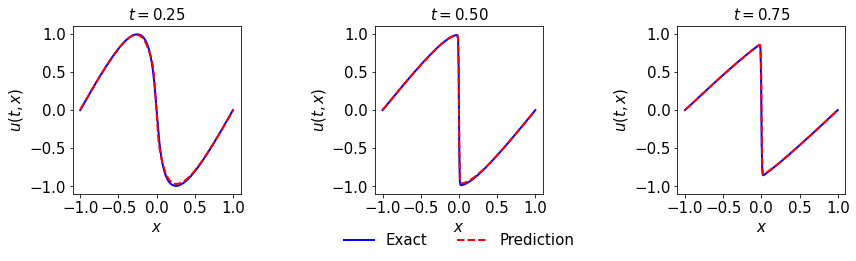

In [18]:
####### Row 1: u(t,x) slices ################## 

""" The aesthetic setting has changed. """

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)

gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 15)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 15)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 15)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()